# The geometry of hidden representations in protein language models

### Import libraries

In [43]:
import sys
sys.path.insert(0,'src/')

import numpy as np
import os

import plotly.graph_objects as go
from plotly.graph_objects import Layout
import plotly.io as pio
import chart_studio.plotly as py
#pio.renderers

from intrinsic_dimension import block_analysis, plot_ID, update_figure
from neighborhood_overlap import mapping, get_data, overlap_label, overlap_layer, plot_no, update_figure



## 1. Intrinsic Dimension

### Download ProteinNet data and estimate ID

In [12]:
path_id = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/id/'

# choose the model you are interested in between: 'esm1b', 'esm1v', 'ProtBert', 'ProtT5', 'esm2-'...
model_id = ['esm1b']
d_model_id = { model:{} for model in model_id}

for model in model_id:
    d_model_id[model]['map'] = mapping[model]
    d_model_id[model]['nlayer'] = d_model_id[model]['map'][2]
    d_model_id[model]['path'] = path_id + model + '/blocks/'
    d_model_id[model]['id'] =  {l : [] for l in d_model_id[model]['nlayer']}


In [14]:
for model in model_id:
    for rep in d_model_id[model]['id'].keys():
        dist_mat = os.path.join(d_model_id[model]['path'],'rep'+str(rep)+'/rep-'+str(rep))
        dim,_,_ = block_analysis(dist_mat, blocks=list(range(1, 21)), fraction=0.9)
        d_model_id[model]['id'][rep] = np.mean(dim)
    


### Plot curve(s)

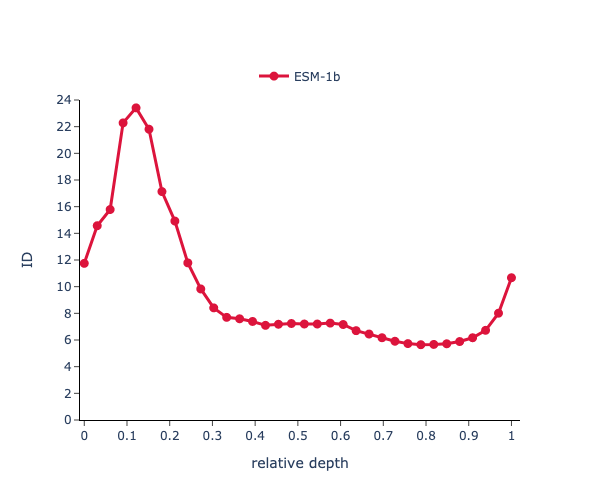

In [50]:
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout).set_subplots(1, 1, horizontal_spacing = 0.1, vertical_spacing = 0.02)

for model in model_id:
    ds_model = d_model_id[model]

    plot_ID(fig,ds_model['nlayer']/(len(ds_model['nlayer'])-1), list(ds_model['id'].values()), ds_model['map'][1], ds_model['map'][0])

fig = update_figure(fig, w = 600, h= 500)
fig.show('png')

## Neighboorhod Overlap 

### Neighborhood rearrangements - ProteinNet

In [3]:
path_pnet = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/pnet/'

# choose the model you are interested in between: ProtBert, ProtT5, esm1b, esm1v, esm2-150M, esm2-15B, esm2-35M, esm2-3B, esm2-650M, esm2-8M
model_pnet = ['esm2-35M','esm2-8M']
d_model_pnet = { model:{} for model in model_pnet}

for model in model_pnet:
    d_model_pnet[model]['map'] = mapping[model]
    d_model_pnet[model]['nlayer'] = len(d_model_pnet[model]['map'][2]) - 1
    d_model_pnet[model]['path'] = path_pnet + model + '/rep'


In [4]:
for model in model_pnet:
    d_model_pnet[model]['ds'] = get_data(d_model_pnet[model]['path'], d_model_pnet[model]['nlayer'], ng = 20)

In [5]:
for model in model_pnet:
    nlayer = d_model_pnet[model]['nlayer']

    d_model_pnet[model]['overlap_first'] = np.array([overlap_layer(d_model_pnet[model]['ds'], l, 0, k = 10) for l in range(nlayer+1)])
    d_model_pnet[model]['overlap_last'] = np.array([overlap_layer(d_model_pnet[model]['ds'], l, nlayer, k = 10) for l in range(nlayer+1)])
    d_model_pnet[model]['overlap_next'] = np.array([overlap_layer(d_model_pnet[model]['ds'], l, l+1, k = 10) for l in range(nlayer)])

In [10]:
fig = go.Figure(layout=Layout(plot_bgcolor='rgba(0,0,0,0)')).set_subplots(1, 3, horizontal_spacing=0.1,vertical_spacing=0.02)

for model in model_pnet:
    nlayer = d_model_pnet[model]['nlayer']
    ds_model = d_model_pnet[model]

    plot_no(fig, nlayer-1, ds_model['overlap_first'], ds_model['map'][1], ds_model['map'][0], r'$\chi^{first}$', 1, 1, True)
    plot_no(fig, nlayer, ds_model['overlap_last'], ds_model['map'][1], ds_model['map'][0], r'$\chi^{last}$', 1, 2, False)
    plot_no(fig, nlayer-1, ds_model['overlap_next'], ds_model['map'][1], ds_model['map'][0], r'$\chi^{l,l+1}$', 1, 3, False)

update_figure(fig, w = 1200, h = 500)

### Remote Homology - SCOPE Superfamily

In [11]:
# choose the model you are interested in between: 'esm1b', 'esm1v', 'ProtBert', 'ProtT5', 'esm2-'...

path_sp = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/rh_sp/'
label_path = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/rh_sp/sp_lab.txt'

model_sp = ['esm2-35M','esm2-8M']
d_model_sp = { model:{} for model in model_sp}

# take mapping values for the model
for model in model_sp:
    d_model_sp[model]['map'] = mapping[model]
    d_model_sp[model]['nlayer'] = len(d_model_sp[model]['map'][2]) - 1
    d_model_sp[model]['path'] = path_sp + model + '/rep'
    d_model_sp[model]['label_path'] = label_path

In [12]:
for model in model_sp:
    d_model_sp[model]['ds'] = get_data(d_model_sp[model]['path'], d_model_sp[model]['nlayer'], d_model_sp[model]['label_path'], ng = 20)

In [13]:
for model in model_sp:
    d_model_sp[model]['overlap_label'] = np.array(overlap_label(d_model_sp[model]['ds'], k = 10))

In [14]:
fig = go.Figure(layout=Layout(plot_bgcolor='rgba(0,0,0,0)')).set_subplots(1, 1, horizontal_spacing=0.1, vertical_spacing=0.02)

for model in model_sp:
    ds_model = d_model_pnet[model]
    plot_no(fig, ds_model['nlayer'], ds_model['overlap_label'], ds_model['map'][1], ds_model['map'][0], r'$\chi^{gt}$')

update_figure(fig, w = 600, h= 500)